In [1]:
from Module_diagnostic_functions import *
from Module_propagation_functions import *
from scipy.optimize import curve_fit

# %matplotlib notebook

In [2]:
##### sampling parameters
var_t = 400    # FWHM pulse duration [fs]
sigT = var_t * 1e-15/2.355
E = 9481.
d_slit = 7e-6

t_res =sigT*2.355/10              # time sampling resolution [s]
ev_window = 4/t_res *1e-15        # total energy window [eV]
ev_res = min(ev_window/800, 1e-3) # energy sampling resolution [eV]

d_source = 100.
fCRL = 4

range_x = 2e-3; range_y = 2e-3
nx =  2048; ny = 2048; nz = 2*round(ev_window/ev_res/2)

x_res = range_x/nx
y_res = range_y/ny
t_window = t_res*nz          # total time window [s]

pulseRange = int(t_window/sigT)
factor = -1 # factor = 0.5

print('nx, ny, nz: {}'.format([nx, ny, nz]))
print('x resolution/range: {}/ {}um'.format(round(x_res*1e6,2), round(range_x*1e6,2)))
print('y resolution/range: {}/ {}um'.format(round(y_res*1e6,2), round(range_y*1e6,2)))
print('time resolution/range: {}/ {}fs'.format(round(t_res*1e15,2), round(t_window*1e15,2)))
print('energy resolution/range: {}/ {}meV'.format(round(ev_res*1e3,2), round(ev_window*1e3,2)))

if_bump = 1
bump_factor = 0.3
if_correct = 0


nx, ny, nz: [2048, 2048, 800]
x resolution/range: 0.98/ 2000.0um
y resolution/range: 0.98/ 2000.0um
time resolution/range: 40.0/ 32000.0fs
energy resolution/range: 0.12/ 100.0meV


3.03 nm deformation


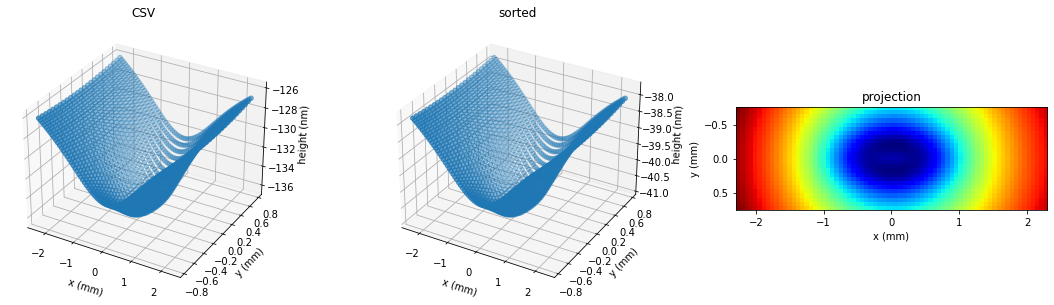

In [3]:
##### reorganize heatbump data as sorted 2d mirror height error
heatbump2d = np.loadtxt(open("heatbump.csv", "rb"), delimiter=",", skiprows=0)
x_mir = heatbump2d[:,0]*1e-3    # [m]
y_mir = heatbump2d[:,1]*1e-3    # [m]
h_mir = heatbump2d[:,2]*1e-3    # [m]

# symmetry about y = 0
h_mir = np.append(h_mir,h_mir[np.argwhere(y_mir!=0)])
x_mir = np.append(x_mir,x_mir[np.argwhere(y_mir!=0)])
y_mir = np.append(y_mir,-y_mir[np.argwhere(y_mir!=0)])

# plot
fig = plt.figure(figsize=(19,5))
ax1 = fig.add_subplot(1,3,1,projection='3d')
ax1.scatter(x_mir*1e3, y_mir*1e3, h_mir*1e9)
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('y (mm)')
ax1.set_zlabel('height (nm)')
ax1.set_title('CSV')

# optical path difference
from scipy import interpolate
import os

# find unique values and sort axis
x_holder = []
y_holder = []

for x in x_mir:
    if x not in x_holder:
        x_holder.append(x)
for y in y_mir:
    if y not in y_holder:
        y_holder.append(y)
x_axis = np.sort(x_holder); nx_mir = np.size(x_axis)
y_axis = np.sort(y_holder); ny_mir = np.size(y_axis)

ntotal = nx_mir*ny_mir

# fill height into sorted array
x = []; y = []; h = []
x, y = np.meshgrid(x_axis, y_axis)
x = x.flatten()
y = y.flatten()

for i in range(ntotal):
    index = np.intersect1d(np.argwhere(x_mir==x[i]),np.argwhere(y_mir==y[i]))[0]
    h.append(h_mir[index])
h = np.array(h)*bump_factor

if if_bump == 0:
    h = np.zeros_like(h)

# plot
ax2 = fig.add_subplot(1,3,2,projection='3d')
ax2.scatter(x*1e3, y*1e3, h*1e9)
ax2.set_xlabel('x (mm)')
ax2.set_ylabel('y (mm)')
ax2.set_zlabel('height (nm)')
ax2.set_title('sorted')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(h.reshape(ny_mir,nx_mir), cmap='jet',
          extent = [x.min()*1e3, x.max()*1e3, y.max()*1e3, y.min()*1e3])
ax3.set_xlabel('x (mm)')
ax3.set_ylabel('y (mm)')
ax3.set_title('projection')
# np.savetxt('heatbump.dat',np.transpose([x,y,h]), delimiter='\t')

deformation = round((h.max() - h.min())*1e9,2)    # nm
print(deformation,'nm deformation')

length: 4.6 mm, width: 1.5 mm


<ipython-input-4-051112fee8d4>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xnew_mir*1e3, ynew_mir*1e3, h_new*1e9,cmap='jet')


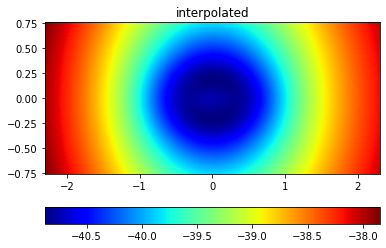

In [4]:
##### generate SRW Optics
nx_m = 1000
ny_m = 4000

from scipy import interpolate
theta = np.deg2rad(15)    # grazing angle
orient = 'x'
x0 = 0    # mirror center, x [m]
y0 = 0    # mirror center, y [m]
xmin = min(x); xmax = max(x); xc = (xmin+xmax)/2
ymin = min(y); ymax = max(y); yc = (ymin+ymax)/2
x = x - x0 - xc
y = y - y0 - yc
xmin = min(x); xmax = max(x)
ymin = min(y); ymax = max(y)
print('length: {:.1f} mm, width: {:.1f} mm'.format(
    (xmax-xmin)*1e3, (ymax-ymin)*1e3))

height_prof_data = np.reshape(h, (ny_mir,nx_mir))
if orient == 'y':
    Mir_OPD = srwlib.SRWLOptT(nx_m, ny_m, (ymax-ymin), (xmax-xmin)*np.sin(theta))
elif orient == 'x':
    Mir_OPD = srwlib.SRWLOptT(ny_m, nx_m, (xmax-xmin)*np.sin(theta), (ymax-ymin))
xnew_mir, ynew_mir = np.mgrid[xmin:xmax:ny_m*1j, ymin:ymax:nx_m*1j]
f = interpolate.RectBivariateSpline(x_axis, y_axis, height_prof_data.T)
h_new = f(xnew_mir[:,0], ynew_mir[0,:])

# plot mirror
plt.figure()
plt.pcolormesh(xnew_mir*1e3, ynew_mir*1e3, h_new*1e9,cmap='jet')
#plt.axis([xnew_mir.min()*1e3, xnew_mir.max()*1e3, ynew_mir.min()*1e3, ynew_mir.max()*1e3])
plt.colorbar(orientation='horizontal')
plt.title('interpolated')

auxMesh = Mir_OPD.mesh
from array import array
foo = array(str(u'd'), [])
# for i in range(150000):
#     foo.append(1.)
foo = array(str(u'd'), [1.]*(nx_m*ny_m))
Mir_OPD.arTr[::2] = foo  # Amplitude Transmission
foo = array(str(u'd'), [])
if orient == 'y':
    for ix in range(ny_m):
        for iy in range(nx_m):
            foo.append(-2 * np.sin(theta) * h_new[ix, iy])
elif orient == 'x':
    for iy in range(nx_m):
        for ix in range(ny_m):
            foo.append(-2 * np.sin(theta) * h_new[ix, iy])
Mir_OPD.arTr[1::2] = foo    # Optical Path Difference (to check sign!)


In [5]:
##### correction
if if_bump == 1:
    if_correct = 0

if if_correct == 1:
    range_y = 250.84e-6; range_x = range_y/np.sin(theta)
    n = 3.791135e-06

    nx_m, ny_m = h_new.shape
    x_m = xnew_mir[:,0]
    y_m = ynew_mir[0]
    x_i = (x_m >= -range_x/2).argmax(); x_f = -x_i; x_f = int(nx_m/2)
    y_i = (y_m >= -range_y/2).argmax(); y_f = -y_i
    x_m = x_m[x_i:x_f]
    y_m = y_m[y_i:y_f]

    h_mir_x = h_new[x_i:x_f,int(ny_m/2)]
    h_mir_y = h_new[int(nx_m/2),y_i:y_f]

    OPD_mir_x = -2 * np.sin(theta) * h_mir_x
    OPD_mir_y = -2 * np.sin(theta) * h_mir_y

    def fit_function(x, r, B, r0):
        return (x-r0)**2/r + B

    optx, covx = curve_fit(fit_function, x_m, OPD_mir_x, p0=[-1.6e3, 2.1e-8, -2.4e-4])
    opty, covy = curve_fit(fit_function, y_m, OPD_mir_y, p0=[3e2, 2.11e-8, -2.97e-10])

    plt.figure()
    plt.plot(x_m*1e3, OPD_mir_x-optx[1], label='x')
    plt.plot(x_m*1e3, fit_function(x_m, optx[0], optx[1], optx[2])-optx[1], 'b-.', label='x-fit')
    plt.plot(y_m*1e3, OPD_mir_y-opty[1], label='y')
    plt.plot(y_m*1e3, fit_function(y_m, opty[0], opty[1], opty[2])-opty[1], 'b-.', label='y-fit')
    plt.title('OPD')

    plt.legend()

    r1 = optx[0]*n; r2 = opty[0]*n; r3 = np.abs(r1*r2/(r1-r2))
    f1 = r1/rCRL(1,1); f2 = r2/rCRL(1,1); f3 = r3/rCRL(1,1)

    if f1 < f2:
        foc_plane_corr = 2    # when focus is tighter in x, add 1D correction lens in y 
    else:
        foc_plane_corr = 1    # when focus is tighter in y, add lens in x

    r_min_corr = np.abs(r3)
    print('correction lens f: {}m, focal plane {}'.format(round(f3,2), foc_plane_corr))
else:
    r_min_corr = 0; foc_plane_corr = 3

In [6]:
##### define beamline optics
def set_optics_CRL(v=None):
    el = []
    pp = []
    names = ['CRL', 'CRL_Planar']
    for el_name in names:
        if el_name == 'CRL':
            # CRL: crl 290.0m
            el.append(srwlib.srwl_opt_setup_CRL(
                _foc_plane=v.op_CRL_foc_plane,
                _delta=v.op_CRL_delta,
                _atten_len=v.op_CRL_atten_len,
                _shape=v.op_CRL_shape,
                _apert_h=v.op_CRL_apert_h,
                _apert_v=v.op_CRL_apert_v,
                _r_min=v.op_CRL_r_min,
                _n=v.op_CRL_n,
                _wall_thick=v.op_CRL_wall_thick,
                _xc=v.op_CRL_x,
                _yc=v.op_CRL_y,
            ))
            pp.append(v.op_CRL_pp)
        elif el_name == 'CRL_Planar':
            # CRL_Planar: drift 290.0m
            el.append(srwlib.SRWLOptD(
                _L=v.op_CRL_Planar_L,
            ))
            pp.append(v.op_CRL_Planar_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_Mirror(v=None):
    el = []
    pp = []
    names = ['Planar', 'Planar_CRL2']
    for el_name in names:
        if el_name == 'Planar':
            # Planar: mirror 300.0m
            el.append(Mir_OPD)
            pp.append(v.op_Planar_pp)
        elif el_name == 'Planar_CRL2':
            # Planar_CRL2: drift 300.0m
            el.append(srwlib.SRWLOptD(
                _L=v.op_Planar_CRL2_L,
            ))
            pp.append(v.op_Planar_CRL2_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_Lens(v=None, drift_offset=-5e-2):
    el = []
    pp = []
    names = ['CRL2', 'CRL2_Watchpoint']
    for el_name in names:
        if el_name == 'CRL2':
            # CRL2: crl 305.0m
            el.append(srwlib.srwl_opt_setup_CRL(
                _foc_plane=v.op_CRL2_foc_plane,
                _delta=v.op_CRL2_delta,
                _atten_len=v.op_CRL2_atten_len,
                _shape=v.op_CRL2_shape,
                _apert_h=v.op_CRL2_apert_h,
                _apert_v=v.op_CRL2_apert_v,
                _r_min=v.op_CRL2_r_min,
                _n=v.op_CRL2_n,
                _wall_thick=v.op_CRL2_wall_thick,
                _xc=v.op_CRL2_x,
                _yc=v.op_CRL2_y,
            ))
            pp.append(v.op_CRL2_pp)
        elif el_name == 'CRL2_Watchpoint':
            # CRL2_Watchpoint: drift 305.0m
            el.append(srwlib.SRWLOptD(
                _L=v.op_CRL2_Watchpoint_L+drift_offset,
            ))
            pp.append(v.op_CRL2_Watchpoint_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_lens_corr(v=None, drift_offset=-5e-2):
    el = []
    pp = []
    names = ['CRL2', 'CRL2corr', 'CRL2_Watchpoint']
    for el_name in names:
        if el_name == 'CRL2':
            # CRL2: crl 305.0m
            el.append(srwlib.srwl_opt_setup_CRL(
                _foc_plane=v.op_CRL2_foc_plane,
                _delta=v.op_CRL2_delta,
                _atten_len=v.op_CRL2_atten_len,
                _shape=v.op_CRL2_shape,
                _apert_h=v.op_CRL2_apert_h,
                _apert_v=v.op_CRL2_apert_v,
                _r_min=v.op_CRL2_r_min,
                _n=v.op_CRL2_n,
                _wall_thick=v.op_CRL2_wall_thick/2,
                _xc=v.op_CRL2_x,
                _yc=v.op_CRL2_y,
            ))
            pp.append(v.op_CRL2_pp)
        elif el_name == 'CRL2corr':
            # CRL2: crl 305.0m
            el.append(srwlib.srwl_opt_setup_CRL(
                _foc_plane=foc_plane_corr,
                _delta=v.op_CRL2_delta,
                _atten_len=v.op_CRL2_atten_len,
                _shape=v.op_CRL2_shape,
                _apert_h=v.op_CRL2_apert_h,
                _apert_v=v.op_CRL2_apert_v,
                _r_min=r_min_corr,
                _n=v.op_CRL2_n,
                _wall_thick=v.op_CRL2_wall_thick/2,
                _xc=v.op_CRL2_x,
                _yc=v.op_CRL2_y,
            ))
            pp.append(v.op_CRL2_pp)
        elif el_name == 'CRL2_Watchpoint':
            # CRL2_Watchpoint: drift 305.0m
            el.append(srwlib.SRWLOptD(
                _L=v.op_CRL2_Watchpoint_L+drift_offset,
            ))
            pp.append(v.op_CRL2_Watchpoint_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_drift(v=None, distance=2.5e-2):
    el = []
    pp = []
    names = ['drift']
    for el_name in names:
        if el_name == 'drift':
            el.append(srwlib.SRWLOptD(
                _L=distance,
            ))
            pp.append(v.op_CRL2_Watchpoint_pp)
    return srwlib.SRWLOptC(el, pp)

In [7]:
varParam = srwl_bl.srwl_uti_ext_options([
    ['name', 's', 'mirror', 'simulation name'],
    
#---Data Folder
    ['fdir', 's', '', 'folder (directory) name for reading-in input and saving output data files'],

    ['gbm_x', 'f', 0.0, 'average horizontal coordinates of waist [m]'],
    ['gbm_y', 'f', 0.0, 'average vertical coordinates of waist [m]'],
    ['gbm_z', 'f', 0.0, 'average longitudinal coordinate of waist [m]'],
    ['gbm_xp', 'f', 0.0, 'average horizontal angle at waist [rad]'],
    ['gbm_yp', 'f', 0.0, 'average verical angle at waist [rad]'],
    ['gbm_ave', 'f', E, 'average photon energy [eV]'],
    ['gbm_pen', 'f', 0.001, 'energy per pulse [J]'],
    ['gbm_rep', 'f', 1, 'rep. rate [Hz]'],
    ['gbm_pol', 'f', 2, 'polarization 1- lin. hor., 2- lin. vert., 3- lin. 45 deg., 4- lin.135 deg., 5- circ. right, 6- circ. left'],
    ['gbm_sx', 'f', 9.787229999999999e-06, 'rms beam size vs horizontal position [m] at waist (for intensity)'],
    ['gbm_sy', 'f', 9.787229999999999e-06, 'rms beam size vs vertical position [m] at waist (for intensity)'],
    ['gbm_st', 'f', sigT, 'rms pulse duration [s] (for intensity)'],
    ['gbm_mx', 'f', 0, 'transverse Gauss-Hermite mode order in horizontal direction'],
    ['gbm_my', 'f', 0, 'transverse Gauss-Hermite mode order in vertical direction'],
    ['gbm_ca', 's', 'c', 'treat _sigX, _sigY as sizes in [m] in coordinate representation (_presCA="c") or as angular divergences in [rad] in angular representation (_presCA="a")'],
    ['gbm_ft', 's', 't', 'treat _sigT as pulse duration in [s] in time domain/representation (_presFT="t") or as bandwidth in [eV] in frequency domain/representation (_presFT="f")'],

#---Calculation Types
    #Single-Electron Intensity distribution vs horizontal and vertical position
    ['si', '', '', 'calculate single-e intensity distribution (without wavefront propagation through a beamline) vs horizontal and vertical position', 'store_true'],
    #Single-Electron Wavefront Propagation
    ['ws', '', '', 'calculate single-electron (/ fully coherent) wavefront propagation', 'store_true'],
    #Multi-Electron (partially-coherent) Wavefront Propagation
    ['wm', '', '', 'calculate multi-electron (/ partially coherent) wavefront propagation', 'store_true'],

    ['w_e', 'f', E, 'photon energy [eV] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ef', 'f', -1.0, 'final photon energy [eV] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ne', 'i', 1, 'number of points vs photon energy for calculation of intensity distribution'],
    ['w_x', 'f', 0.0, 'central horizontal position [m] for calculation of intensity distribution'],
    ['w_rx', 'f', range_x, 'range of horizontal position [m] for calculation of intensity distribution'],
    ['w_nx', 'i', nx, 'number of points vs horizontal position for calculation of intensity distribution'],
    ['w_y', 'f', 0.0, 'central vertical position [m] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ry', 'f', range_y, 'range of vertical position [m] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ny', 'i', ny, 'number of points vs vertical position for calculation of intensity distribution'],
    ['w_smpf', 'f', factor, 'sampling factor for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_meth', 'i', 2, 'method to use for calculation of intensity distribution vs horizontal and vertical position: 0- "manual", 1- "auto-undulator", 2- "auto-wiggler"'],
    ['w_prec', 'f', 0.01, 'relative precision for calculation of intensity distribution vs horizontal and vertical position'],

    ['w_ft', 's', 'f', 'presentation/domain: "f"- frequency (photon energy), "t"- time'],

    ['w_u', 'i', 2, 'electric field units: 0- arbitrary, 1- sqrt(Phot/s/0.1%bw/mm^2), 2- sqrt(J/eV/mm^2) or sqrt(W/mm^2), depending on representation (freq. or time)'],
    ['si_pol', 'i', 6, 'polarization component to extract after calculation of intensity distribution: 0- Linear Horizontal, 1- Linear Vertical, 2- Linear 45 degrees, 3- Linear 135 degrees, 4- Circular Right, 5- Circular Left, 6- Total'],
    ['si_type', 'i', 0, 'type of a characteristic to be extracted after calculation of intensity distribution: 0- Single-Electron Intensity, 1- Multi-Electron Intensity, 2- Single-Electron Flux, 3- Multi-Electron Flux, 4- Single-Electron Radiation Phase, 5- Re(E): Real part of Single-Electron Electric Field, 6- Im(E): Imaginary part of Single-Electron Electric Field, 7- Single-Electron Intensity, integrated over Time or Photon Energy'],
    
    ['si_fn', 's', '', 'file name for saving calculated single-e intensity distribution (without wavefront propagation through a beamline) vs horizontal and vertical position'],
    ['si_pl', 's', '', 'plot the input intensity distributions in graph(s): ""- dont plot, "x"- vs horizontal position, "y"- vs vertical position, "xy"- vs horizontal and vertical position'],
    ['ws_fni', 's', '', 'file name for saving propagated single-e intensity distribution vs horizontal and vertical position'],
    ['ws_pl', 's', '', 'plot the resulting intensity distributions in graph(s): ""- dont plot, "x"- vs horizontal position, "y"- vs vertical position, "xy"- vs horizontal and vertical position'],

    #to add options
    ['op_r', 'f', d_source, 'longitudinal position of the first optical element [m]'],
    # Former appParam:
    ['rs_type', 's', 'g', 'source type, (u) idealized undulator, (t), tabulated undulator, (m) multipole, (g) gaussian beam'],

#---Beamline optics:
    # CRL: crl
    ['op_CRL_foc_plane', 'f', 3, 'focalPlane'], # 1-H; 2-V; 3-Both
    ['op_CRL_delta', 'f', 3.791135e-06, 'refractiveIndex'],
    ['op_CRL_atten_len', 'f', 0.008387, 'attenuationLength'],
    ['op_CRL_shape', 'f', 1, 'shape'],
    ['op_CRL_apert_h', 'f', range_x, 'horizontalApertureSize'],
    ['op_CRL_apert_v', 'f', range_y, 'verticalApertureSize'],
    ['op_CRL_r_min', 'f', rCRL(d_source, 1), 'tipRadius'],
    ['op_CRL_wall_thick', 'f', 5e-05, 'tipWallThickness'],
    ['op_CRL_x', 'f', 0.0, 'horizontalOffset'],
    ['op_CRL_y', 'f', 0.0, 'verticalOffset'],
    ['op_CRL_n', 'i', 1, 'numberOfLenses'],

    # CRL_Planar: drift
    ['op_CRL_Planar_L', 'f', 10.0, 'length'],

    # Planar: mirror
    ['op_Planar_hfn', 's', 'mirror_2d.dat', 'heightProfileFile'],
    ['op_Planar_dim', 's', 'x', 'orientation'],
    ['op_Planar_ang', 'f', np.deg2rad(15), 'grazingAngle'],
    ['op_Planar_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_Planar_size_x', 'f', range_x/np.sin(np.deg2rad(15)), 'horizontalTransverseSize'],
    ['op_Planar_size_y', 'f', range_y/np.sin(np.deg2rad(15)), 'verticalTransverseSize'],

    # Planar_CRL2: drift
    ['op_Planar_CRL2_L', 'f', 2.0, 'length'],

    # CRL2: crl
    ['op_CRL2_foc_plane', 'f', 3, 'focalPlane'],
    ['op_CRL2_delta', 'f', 3.775973e-06, 'refractiveIndex'],
    ['op_CRL2_atten_len', 'f', 0.00843, 'attenuationLength'],
    ['op_CRL2_shape', 'f', 1, 'shape'],
    ['op_CRL2_apert_h', 'f', 0.001, 'horizontalApertureSize'],
    ['op_CRL2_apert_v', 'f', 0.001, 'verticalApertureSize'],
    ['op_CRL2_r_min', 'f', rCRL(fCRL,1)*0.9960006699840549, 'tipRadius'],
    ['op_CRL2_wall_thick', 'f', 8e-05, 'tipWallThickness'],
    ['op_CRL2_x', 'f', 0.0, 'horizontalOffset'],
    ['op_CRL2_y', 'f', 0.0, 'verticalOffset'],
    ['op_CRL2_n', 'i', 1, 'numberOfLenses'],

    # CRL2_Watchpoint: drift
    ['op_CRL2_Watchpoint_L', 'f', fCRL, 'length'],
    
#---Propagation parameters
#                                  [0][1] [2] [3][4] [5]  [6]  [7]  [8]  [9] [10] [11]
    ['op_CRL_pp', 'f',             [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'CRL'],
    ['op_CRL_Planar_pp', 'f',      [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'CRL_Planar'],
    ['op_Planar_pp', 'f',          [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'Planar'],
    ['op_Planar_CRL2_pp', 'f',     [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'Planar_CRL2'],
    ['op_CRL2_pp', 'f',            [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'CRL2'],
    ['op_CRL2_Watchpoint_pp', 'f', [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'CRL2_Watchpoint'],
    ['op_fin_pp', 'f',             [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'final post-propagation (resize) parameters'],

    #[ 0]: Auto-Resize (1) or not (0) Before propagation
    #[ 1]: Auto-Resize (1) or not (0) After propagation
    #[ 2]: Relative Precision for propagation with Auto-Resizing (1. is nominal)
    #[ 3]: Allow (1) or not (0) for semi-analytical treatment of the quadratic (leading) phase terms at the propagation
    #[ 4]: Do any Resizing on Fourier side, using FFT, (1) or not (0)
    #[ 5]: Horizontal Range modification factor at Resizing (1. means no modification)
    #[ 6]: Horizontal Resolution modification factor at Resizing
    #[ 7]: Vertical Range modification factor at Resizing
    #[ 8]: Vertical Resolution modification factor at Resizing
    #[ 9]: Type of wavefront Shift before Resizing (not yet implemented)
    #[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
    #[11]: New Vertical wavefront Center position after Shift (not yet implemented)
    #[12]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Horizontal Coordinate
    #[13]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Vertical Coordinate
    #[14]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Longitudinal Coordinate
    #[15]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Horizontal Coordinate
    #[16]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Vertical Coordinate
])

In [8]:
def plot_spatial_from_wf(_wfr, if_slice=0, if_log=0):
    # plot wavefront projection (y vs x) or lineout (if_slice)
    nx, ny, nz = get_dimension(_wfr)
    img = get_intensity(_wfr, domain='t').sum(axis=-1)
    axis_x, axis_y = get_axis_sp(_wfr)
    if if_slice == 1:
        if nx >= ny:
            plt.plot(axis_x*1e6, img[int(ny/2)]/img[int(ny/2)].max())
            plt.xlabel(r'x ($\mu$m)')
        else:
            plt.plot(axis_y*1e6, img[:,int(nx/2)]/img[:,int(nx/2)].max())
            plt.xlabel(r'y ($\mu$m)')
        plt.ylabel('intensity (a.u.)')
    else:
        if if_log == 1:
            img = img/img.max()
            img = img + 1e-30
            img = np.log(img)
        plt.imshow(img,cmap='jet',
            extent = [axis_x.min()*1e6, axis_x.max()*1e6, axis_y.max()*1e6, axis_y.min()*1e6],
            interpolation=interpolation)
        plt.colorbar()
        plt.xlabel(r'x ($\mu$m)')
        plt.ylabel(r'y ($\mu$m)')
        if if_log == 1:
            cmin = np.max(img)-15; plt.clim(cmin)
#         else:
#             plt.clim([0, 8000])
#             plt.clim([-2,12])

def plot_wfr_diagnostic(_wfr, label=None, dir_plot=None, range_x=None, range_y=None, if_slice=1, if_log=0, i=0, i_start=0):
    '''
    if_slice: y = 0 slice only or full projection
    if_log: log scale in imshow plots
    i: plot index, make I/O easier
    i_start: minimum plot index, only indices >= i_start will be plotted
    '''
    if i>= i_start:
        t0 = time()
        np.seterr(divide = 'ignore')
        nx, ny, nz = get_dimension(_wfr)
        # I/O plot name
        nx, ny, nz = get_dimension(_wfr)    # get dimension
        if if_log == 1:
            pltname = '{}_{}_nx{}_ny{}_nz{}_log.png'.format(i,label,nx,ny,nz)
        else:
            pltname = '{}_{}_nx{}_ny{}_nz{}.png'.format(i,label,nx,ny,nz)

        ''' some calculations '''
        # space
        title_space = label + ', '
        axis_x, axis_y = get_axis_sp(_wfr)      # spatial axis [m]
        res_x = round(np.abs(axis_x[1] - axis_x[0])*1e6,2)  # spatial resolution
        try:
            cent_x, cent_y, fwhm_x, fwhm_y = fit_pulse_position(_wfr)   # fit for pulse position and width
            xstart = cent_x - fwhm_x*10; xfin = cent_x + fwhm_x*10
            ystart = cent_y - fwhm_y*10; yfin = cent_y + fwhm_y*10
            title_space+= '\nfwhm: {}um, '.format(round(fwhm_x*1e6,2))
        except:
            print('fit failed')
            xstart = -range_x/2; xfin = range_x/2
            ystart = -range_y/2; yfin = range_y/2
        xstart = max(axis_x.min()*1e6, xstart*1e6); xfin = min(axis_x.max()*1e6, xfin*1e6)
        ystart = max(axis_y.min()*1e6, ystart*1e6); yfin = min(axis_y.max()*1e6, yfin*1e6)
        if range_x != None:
            xstart = -range_x/2*1e6; xfin = range_x/2*1e6
        if range_y != None:
            ystart = -range_y/2*1e6; yfin = range_y/2*1e6
        title_space += 'pxl: {}um'.format(res_x)
        
        ''' plots '''
        plt.figure()
        # space
        plot_spatial_from_wf(_wfr, if_slice=if_slice, if_log=if_log)
        plt.title(title_space); plt.xlim([xstart, xfin])
        if if_slice != 1: plt.ylim([ystart, yfin])

        plt.savefig(dir_plot+pltname)
        plt.close('all')
        np.seterr(divide = 'warn')
#         print('plot lasted {}s'.format(round(time()-t0,2)))
#     else:
#         print('plot skipped')

def get_intensity_slice(_wfr, axis='x'):
    nx, ny, nz = get_dimension(_wfr)
    intensity = get_intensity(_wfr, domain='t', polarization='total')[:,:,0]
    if axis == 'x':
        intensity_slice = intensity[int(ny/2)]
        intensity_projection = intensity.sum(axis=0)
        axis_sp = get_axis_sp(_wfr)[0]
    elif axis == 'y':
        intensity_slice = intensity[:,int(nx/2)]
        intensity_projection = intensity.sum(axis=1)
        axis_sp = get_axis_sp(_wfr)[1]
    return axis_sp, intensity_slice, intensity_projection


In [9]:
def main(varParam, delta_d = [0], dir_plot=None, if_log=0, if_slice=0, i_start=0):
    time_stamp=time()
    range_x = 100e-6; range_y = range_x; range_z = 50e-2    # plot range [m]
    # initialization
    v = srwl_bl.srwl_uti_parse_options(varParam, use_sys_argv=True)
    v.si = True
    srwl_bl.SRWLBeamline(_name=v.name).calc_all(v)

    # incident beam
    wfr = v.w_res; i_plot = 1
    plot_wfr_diagnostic(wfr, label='input', dir_plot=dir_plot, i=i_plot, if_log=1, if_slice=if_slice, i_start=i_start)
    srwlpy.SetRepresElecField(wfr, 'f')

    # propagation
    label = 'before mirror'; print('Propagating to {}: '.format(label), end=''); i_plot+=1; t0 = time()
    bl = set_optics_CRL(v); srwlpy.PropagElecField(wfr, bl); print('done in', round(time() - t0, 3), 's\n')
    plot_wfr_diagnostic(wfr, label=label, dir_plot=dir_plot, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)
    
    label = 'before lens'; print('Propagating to {}: '.format(label), end=''); i_plot+=1; t0 = time()
    bl = set_optics_Mirror(v); srwlpy.PropagElecField(wfr, bl); print('done in', round(time() - t0, 3), 's\n')
    plot_wfr_diagnostic(wfr, label=label, dir_plot=dir_plot, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)
    
    label = '{}mm away from focal plane'.format(round(np.min(delta_d)*1e3,2)); i_plot+=1; t0 = time()
    if if_correct == 1:
        bl = set_optics_lens_corr(v, drift_offset=np.min(delta_d))
    else:
        bl = set_optics_Lens(v, drift_offset=np.min(delta_d))
    srwlpy.PropagElecField(wfr, bl);# print('done in', round(time() - t0, 3), 's\n')
    if np.abs(delta_d.min()) <= range_z/2:
        plot_wfr_diagnostic(wfr, label=label, dir_plot=dir_plot, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)

    axis_x, slice_x, projection_x = get_intensity_slice(wfr, axis='x')
    axis_y, slice_y, projection_y = get_intensity_slice(wfr, axis='y')

    # expand axis for interpolation
    x_new = np.linspace(axis_x.min(), axis_x.max(), axis_x.size * 5)
    y_new = np.linspace(axis_y.min(), axis_y.max(), axis_y.size * 5)
    slice_x_list = np.zeros((delta_d.size, x_new.size))
    slice_y_list = np.zeros((delta_d.size, y_new.size))
    projection_x_list = np.zeros_like(slice_x_list)
    projection_y_list = np.zeros_like(slice_x_list)
    total_intensity_list = np.zeros(delta_d.size)
    fx = interpolate.interp1d(axis_x, slice_x, kind='linear', bounds_error=False, fill_value=0); slice_x_list[0] = fx(x_new)
    fy = interpolate.interp1d(axis_y, slice_y, kind='linear', bounds_error=False, fill_value=0); slice_y_list[0] = fy(y_new)

    # drift to slices around
    for j, d in enumerate(delta_d):
        if j == 0: continue
        drift_distance = np.abs(delta_d[j] - delta_d[j-1])
        label = '{}mm away from focal plane'.format(round(d*1e3,2)); i_plot+=1; t0 = time()
        if j%50 == 0: print('{}'.format(label), round(time()-time_stamp,2))
        bl = set_optics_drift(v, distance=drift_distance); srwlpy.PropagElecField(wfr, bl);# print('done in', round(time() - t0, 3), 's\n')
        if np.abs(d) <= range_z/2:
            plot_wfr_diagnostic(wfr, label=label, dir_plot=dir_plot, range_x=range_x, range_y=range_y, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)
        
        # get primary intensity slices
        axis_x, slice_x, projection_x = get_intensity_slice(wfr, axis='x')
        axis_y, slice_y, projection_y = get_intensity_slice(wfr, axis='y')
        
        fx = interpolate.interp1d(axis_x, slice_x, kind='linear', bounds_error=False, fill_value=0)
        slice_x_list[j] = fx(x_new)
        fy = interpolate.interp1d(axis_y, slice_y, kind='linear', bounds_error=False, fill_value=0)
        slice_y_list[j] = fy(y_new)
        fx = interpolate.interp1d(axis_x, projection_x, kind='linear', bounds_error=False, fill_value=0)
        projection_x_list[j] = fx(x_new)
        fy = interpolate.interp1d(axis_y, projection_y, kind='linear', bounds_error=False, fill_value=0)
        projection_y_list[j] = fy(y_new)
        total_intensity_list[j] = projection_x_list[j].sum()
        
    print('\n\neverything lasted: {}s'.format(round(time()-time_stamp,2)))
    return x_new, slice_x_list, projection_x_list, y_new, slice_y_list, projection_y_list, total_intensity_list


In [10]:
if if_bump == 0:
    title = 'flat_mirror'
else:
    title = '{}nm_heat_bump'.format(deformation)
if if_correct == 1:
    title += '_corr'

dir_out = 'output/'; mkdir(dir_out)
dir_plot = dir_out+title+'/'; mkdir(dir_plot)
delta_d = np.linspace(-fCRL/4,fCRL/4,401)
# delta_d = delta_d[np.abs(delta_d)<=25e-2]+0.238

if __name__ == '__main__':
    axis_x, slice_x_list, projection_x_list, axis_y, slice_y_list, projection_y_list, total_intensity_list = main(varParam, delta_d=delta_d, dir_plot=dir_plot, if_log=0, if_slice=0, i_start=0)


Gaussian beam electric field calculation ... completed (lasted 0.612 s)
Extracting intensity and saving it to a file ... completed (lasted 0.24 s)


C:\Users\nanw0\anaconda3\envs\SRW\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Propagating to before mirror: Optical Element Setup: CRL Focal Length: 100.0 m
done in 3.462 s

Propagating to before lens: done in 1.767 s

Optical Element Setup: CRL Focal Length: 4.0 m
-750.0mm away from focal plane 114.6
-500.0mm away from focal plane 219.15
-250.0mm away from focal plane 325.93
0.0mm away from focal plane 476.53
250.0mm away from focal plane 635.16
500.0mm away from focal plane 735.19
750.0mm away from focal plane 833.99
1000.0mm away from focal plane 933.37


everything lasted: 935.34s


<ipython-input-11-ceac014ad06a>:26: RuntimeWarning: divide by zero encountered in log
  img = np.log(intensity_slice_list.T)


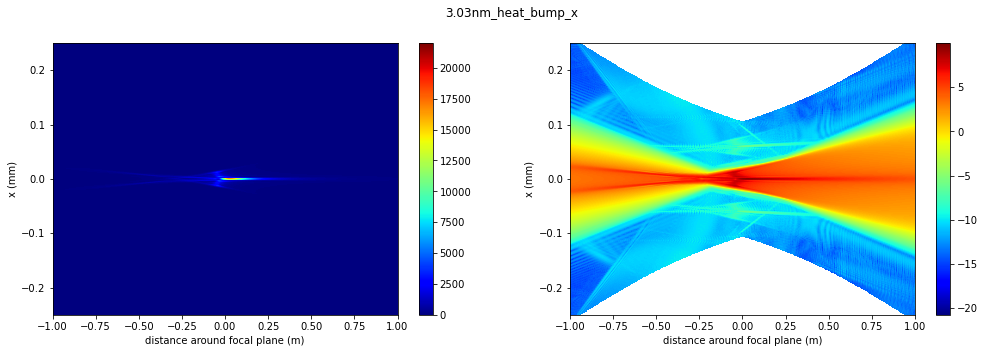

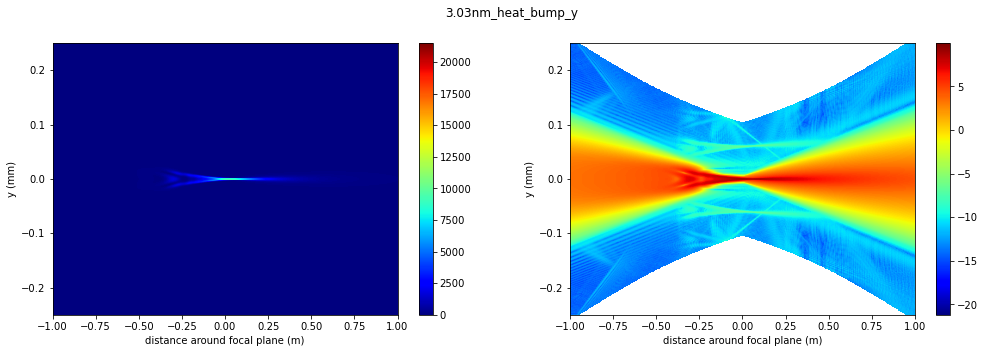

In [11]:
# plot x
range_x = 500e-6; range_y = range_x
for dimension in ['x','y']:
    if dimension == 'x':
        axis_sp = axis_x
        intensity_slice_list = slice_x_list
        plt_title = title+'_x'
    elif dimension == 'y':
        axis_sp = axis_y
        intensity_slice_list = slice_y_list
        plt_title = title+'_y'

    plt.figure(figsize=(17,5))
    plt.subplot(1,2,1)    # linear scale
    img = intensity_slice_list.T
    plt.imshow(img, cmap='jet',
              extent=[delta_d.min(), delta_d.max(), axis_sp.max()*1e3, axis_sp.min()*1e3])
    plt.xlabel('distance around focal plane (m)')
    plt.ylabel('{} (mm)'.format(dimension))
    plt.axis('tight')
    plt.ylim([-range_x/2*1e3,range_x/2*1e3])
    plt.colorbar()


    plt.subplot(1,2,2)    # log scale
    img = np.log(intensity_slice_list.T)
    plt.imshow(img, cmap='jet',
              extent=[delta_d.min(), delta_d.max(), axis_sp.max()*1e3, axis_sp.min()*1e3])
#     plt.clim(img.max()-15)
    plt.xlabel('distance around focal plane (m)')
    plt.ylabel('{} (mm)'.format(dimension))
    plt.axis('tight')
    plt.ylim([-range_y/2*1e3,range_y/2*1e3])
    plt.colorbar()
    plt.suptitle(plt_title)

    plt.savefig(dir_out+'{}.png'.format(plt_title))

In [12]:
###### I/O
axis_x, slice_x_list, projection_x_list, axis_y, slice_y_list, projection_y_list, total_intensity_list
filename = '{}.h5'.format(title)
with h5py.File(dir_out+filename,'w') as f:
    f.create_dataset('lens_x', data=xnew_mir)
    f.create_dataset('lens_y', data=ynew_mir)
    f.create_dataset('lens_h', data=h_new)
    f.create_dataset('axis_x', data=axis_x)
    f.create_dataset('axis_y', data=axis_y)
    f.create_dataset('axis_z', data=delta_d)
    f.create_dataset('intensity', data=total_intensity_list)
    f.create_dataset('slice_x', data=slice_x_list)
    f.create_dataset('slice_y', data=slice_y_list)
    f.create_dataset('projection_x', data=projection_x_list)
    f.create_dataset('projection_y', data=projection_y_list)


In [13]:
print('focus x:', round(delta_d[np.argmax(slice_x_list[:,np.abs(axis_x)<=1e-6].sum(axis=1))],3))
print('focus y:', round(delta_d[np.argmax(slice_y_list[:,np.abs(axis_y)<=1e-6].sum(axis=1))],3))

focus x: 0.025
focus y: 0.03


In [14]:
### save total intensity at each z for normalization
### near focus propagate at finer resolution to save time